# Results 1. Engineering genetic variation in metabolism
We consider whole-genome metabolic reconstructions and generate variability in gene dosages as a result of the genetic variability in a population. Dosages are relative to a reference value, i.e., reduced enzymatic performance in line with earlier works on metabolism and are later interpreted quantitatively in the model by gene-reaction rules. These rules define which (and how) genes participate in reactions.

But before starting we need to load the model...

### Load COBRA model

In [1]:
import cobra
import numpy as np
import pickle as pk
from tqdm import tqdm
from datetime import datetime
from multiprocessing import Pool
from matplotlib import pyplot as plt
from QuantitativeMutation import QuantitativeMutation

MODEL_NAME  = 'yeast_iND750'
SOLVER_NAME = 'glpk'


#Define minimal medium...
minimal_medium = {}        
minimal_medium.update( {'EX_o2_e' :     2 }) #... oxygen
minimal_medium.update( {'EX_h2o_e' : 9999 }) #... water
minimal_medium.update( {'EX_co2_e' : 9999 }) #... carbon dioxyde
minimal_medium.update( {'EX_nh4_e' : 9999 }) #... ammonia
minimal_medium.update( {'EX_pi_e'  : 9999 }) #... phosphate
minimal_medium.update( {'EX_so4_e' : 9999 }) #... sulphate
minimal_medium.update( {'EX_k_e'   : 9999 }) #... potassium
minimal_medium.update( {'EX_na1_e' : 9999 }) #... sodium

#... and standard medium
std_medium = minimal_medium.copy()
std_medium.update( {  'EX_glc__D_e' : 20 } )


# Load specific metabolic model...
Q = QuantitativeMutation( './metabolic_models/%s.json' % MODEL_NAME , verbose=True)

#... set solver
Q.model.solver = SOLVER_NAME

#... and standard medium
Q.model.medium = std_medium



#Compute WT solution
wt_solution  = Q.optimize()
wt_growthrate= Q.slim_optimize()
print('Wild-type growth rate %1.3f' % Q.slim_optimize() )
print('')
print(datetime.now())

Academic license - for non-commercial use only - expires 2022-08-06
Using license file /home/pyubero/gurobi.lic
Loaded model iND750 from user file.
Biomass reaction id is BIOMASS_SC4_bal
The model has 750 genes and 1266 reactions.
... number of exchange reactions:	116
... number of non-exchange reactions:	1148
Wild-type growth rate 0.514

2022-05-15 11:30:20.580955


# 1. Compute maximal bounds of the fluxes under random media.
To compute the effect of a quantitative reduction in gene dosage, or equivalently enzyme efficiency, we first need to compute the wild type "reference" bounds of each reaction. These bounds are constituted by the maximum (and minimum if reversible) reaction fluxes observed in many optimal solutions of metabolisms exposed to random environments, and random genetic backgrounds. 

## 1a. Generate (or load) a list of valid random media
Random environments are generated following a previous protocol. Briefly, we supplement the minimal medium with an additional number of components such that the probability of including any component follows an exponential distribution with mean $m=0.10$ (other values produce similar results). Then, for every component, we obtain their maximum import rates from a uniform distribution between 0 and 20 mmol/gDW/h. To avoid including arbitrarily rich media, we consider those with richness inferior, or equal to that of the standard medium. 

Usually $10^4$ takes about 1h, while $10^3$ take about 10min.


In [2]:
GENERATE_MEDIA_LIST = False   # set to False if a file with media already exists, or True otherwise
#...
RICHNESS    = 0.10            #... scale of the exponential distribution as described in the reference
MEDIA_LIST  = [std_medium,]   #... initialize the list containing the standard media
SAMPLES     = 10_000          #... number of random environments that you wish to compute
BATCH_SIZE  = 200             #... environments are computed in batches of BATCH_SIZE
MIN_GR      = 0.01            #... minimum growth rate to consider a model viable
MAX_GR      = wt_growthrate   #... maximum growth rate of valid media
_total      = 0               #... _total monitors the total number of media tested


#...
FILENAME    = 'Data_1_random_media_list_%1.2f.pkl' % RICHNESS


# This parallel function generates a random medium and returns whether it is valid (suc=True)
def parallel_function(dummy):
    np.random.seed()

    # Generate random medium
    new_medium =  Q.random_medium( m=RICHNESS, minimal=minimal_medium, upper_lim = 20, method='linear' )

    # Set medium, and optimize wild type
    with Q.model:
        Q.set_medium( new_medium )
        suc = MIN_GR<Q.model.slim_optimize()<MAX_GR

    # Return suc=True if the medium supports a growth >min_gr and <max_gr
    return suc, new_medium

    

    
if GENERATE_MEDIA_LIST:
    
    # Open Pool and initialize progress bar
    with Pool( processes=50) as p, tqdm(total=SAMPLES) as pbar:

        # For any number of batches necessary
        while len(MEDIA_LIST)<SAMPLES:

            # Run a batch...
            it = p.imap_unordered( parallel_function, range(BATCH_SIZE) )

            #... parse the batch and store the medium when suc == True
            for results in it:
                _total += 1

                if results[0]:
                    MEDIA_LIST.append( results[1] )
                    pbar.update(1)
                    if len(MEDIA_LIST)==SAMPLES:
                        break
                        
    # Finished computing media list
    print('Efficiency: %1.4f' % ( len(MEDIA_LIST)/_total ) )

    # Export media list
    with open(FILENAME, '+wb') as handle:
        pk.dump( MEDIA_LIST, handle)
    
    print('Random media list with %d media exported! ' % len(MEDIA_LIST), datetime.now())

#...
else:
    
    # Load media list
    with open(FILENAME, 'rb') as handle:
        MEDIA_LIST = pk.load(handle)
        
    print('Loaded random media list with %d entries. ' % len(MEDIA_LIST), datetime.now() )
        

Loaded random media list with 10000 entries.  2022-05-15 11:30:21.029152


#### [plot] Number of components in each medium

100%|██████████| 10000/10000 [00:03<00:00, 2750.35it/s]


Mean number of components 17.80 +/- 2.83


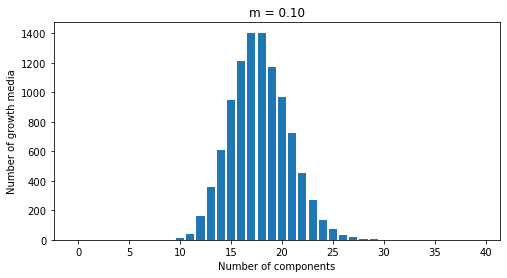

In [3]:
# Build the media composition matrix
media_matrix = np.zeros((Q.N_EX_RXNS, len(MEDIA_LIST) ) )

for jj in tqdm( range(len(MEDIA_LIST))):
    medium = MEDIA_LIST[jj]
    for elem in medium:
        idx = np.argwhere( np.array(Q.EX_RXNS)== elem )[0][0]
        media_matrix[idx,jj] = medium[elem]

# Compute the number of components of each medium        
noc = np.sum(media_matrix!=0, axis=0)

plt.figure( figsize=(8,4) )
plt.bar( range(40), [np.sum( noc==jj) for jj in range(40)] )
plt.xlabel('Number of components')
plt.ylabel('Number of growth media');
plt.title('m = %1.2f' % RICHNESS);

print('Mean number of components %1.2f +/- %1.2f' % (np.mean(noc), np.std(noc)) )

## 1b. Compute solutions across all media in the list.
The wild type reference bounds will be the maximum/minimum fluxes found in the solutions in the list of media.





In [4]:
LOAD_BOUNDS  = True             #... if you wish to load instead of calculate everything
EXPORT_DATA  = False            #... if you want to export the maximal bounds to a csv file
RICHNESS     = 0.10
SAMPLES      = len(MEDIA_LIST)  #... this should remain unchanged to len(MEDIA_LIST)


# Reset bounds
Q.reset_bounds()


if LOAD_BOUNDS:
    Q.load_bounds('Data_1_bounds_%1.2f.csv' % RICHNESS)    
    
    
if not LOAD_BOUNDS:
    
    # Compute bounds
    print('\nComputing bounds.')
    Q.compute_bounds(
                 media_list  = MEDIA_LIST, 
                 pfba        = True, 
                 kd_frac     = 1,
                 nprocessors = 50, 
                 chunksize   = 50)
    

    if EXPORT_DATA:
        Q.save_bounds('Data_1_bounds_%1.2f.csv' % RICHNESS, description='nsamples=%d.' % SAMPLES)

Maxbounds reset to +/- 999 on 2022-05-15 11:30:26.120014.
Maxbounds loaded from Data_1_bounds_0.10.csv on 2022-05-15 11:30:26.148445.


#### [plot] Plot the maximal bounds

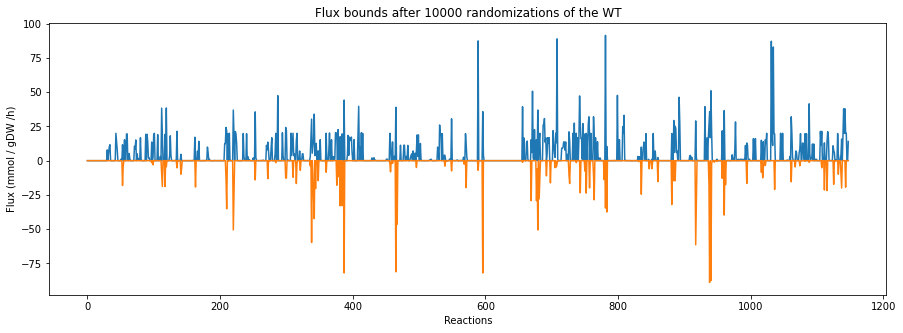

In [5]:
plt.figure( figsize=(15,5))

plt.plot( [Q.upper_bounds[rid] for rid in Q.NEX_RXNS] )
plt.plot( [Q.lower_bounds[rid] for rid in Q.NEX_RXNS] )

plt.xlabel('Reactions')
plt.ylabel('Flux (mmol / gDW /h)')
plt.title('Flux bounds after %d randomizations of the WT' % SAMPLES );

#### [plot] Compare the bounds computed with different methods (or distributions Exp[$\lambda$])

    -> `bounds_0.05.csv` contains bounds with media computed as in [Zhang and Wang] with $\lambda=0.05$
    -> `bounds_0.10.csv` contains bounds with media computed as in [Zhang and Wang] with $\lambda=0.10$ used by default


Linear correlation R_upper = 0.9803
Linear correlation R_lower = 0.9875


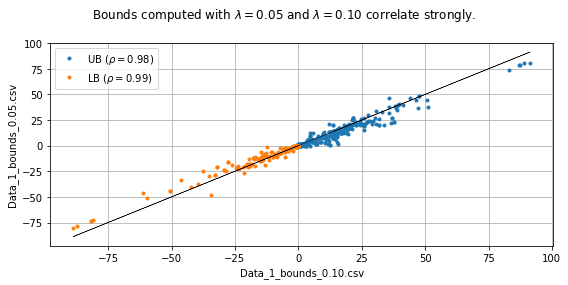

In [6]:
bounds1 = "Data_1_bounds_0.10.csv"
bounds2 = "Data_1_bounds_0.05.csv"

#load bounds 1
lower1 = np.zeros( (Q.N_NEX_RXNS),)
upper1 = np.zeros( (Q.N_NEX_RXNS),)
with open(bounds1,'r') as f:
    for jj in range(Q.N_NEX_RXNS):
        data = f.readline().split('\n')[0].split(';')
        lower1[jj] = float( data[2] )
        upper1[jj] = float( data[1] )

# Load bounds 2
lower2 = np.zeros( (Q.N_NEX_RXNS),)
upper2 = np.zeros( (Q.N_NEX_RXNS),)
with open(bounds2,'r') as f:
    for jj in range(Q.N_NEX_RXNS):
        data = f.readline().split('\n')[0].split(';')
        lower2[jj] = float( data[2] )
        upper2[jj] = float( data[1] )

rho_ub = np.corrcoef(upper1, upper2)[0,1]
rho_lb = np.corrcoef(lower1, lower2)[0,1]
print('Linear correlation R_upper = %1.4f' % (rho_ub) )
print('Linear correlation R_lower = %1.4f' % (rho_lb) )



plt.figure( figsize=(8,4))

plt.plot(upper1, upper2,'.')
plt.plot(lower1, lower2,'.')
plt.plot(lower1, lower1,'k',lw=0.5)
plt.plot(upper1, upper1,'k',lw=0.5)


plt.xlabel(bounds1)
plt.ylabel(bounds2)
plt.legend((r'UB ($\rho=%1.2f$)' % rho_ub,r'LB ($\rho=%1.2f$)' % rho_lb))
plt.grid()


plt.suptitle('Bounds computed with $\lambda=0.05$ and $\lambda=0.10$ correlate strongly.')
plt.tight_layout();